## Goal of the Competition
The goal of this competition is to predict if a person has any of three medical conditions. You are being asked to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). You will create a model trained on measurements of health characteristics.

To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

Your work will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

## Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

### Files and Field Descriptions
**train.csv** - The training set.
- `Id` Unique identifier for each observation.
- `AB`-`GL` Fifty-six anonymized health characteristics. All are numeric except for `EJ`, which is categorical.
- `Class` A binary target: `1` indicates the subject has been diagnosed with one of the three conditions, `0` indicates they have not.

**test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.

**greeks.csv** - Supplemental metadata, only available for the training set.
- `Alpha` Identifies the type of age-related condition, if present.
- `A` No age-related condition. Corresponds to class `0`.
- `B`, `D`, `G` The three age-related conditions. Correspond to class `1`.
- `Beta`, `Gamma`, `Delta` Three experimental characteristics.
- `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page for more details.

### Import libs

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt, floor
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, KFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    RocCurveDisplay)
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

# Random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Functions definitions

In [2]:
def balanced_logloss(y_true, y_score):
    """
    Calculates balanced logloss.
    """
    if len(y_score.shape) == 1 or (len(y_score.shape) == 2 and y_score.shape[-1] == 1):
        y_score = np.hstack((1 - y_score, y_score))

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_score = y_score / y_score.sum(axis=1)[:, None]
    y_score = np.clip(y_score, 1e-15, 1 - 1e-15)

    nc = np.bincount(y_true)

    y_0 = np.array([1 if i == 0 else 0 for i in y_true])
    y_1 = np.array([1 if i == 1 else 0 for i in y_true])
    
    if nc[0] > 0:
        log_loss_0 = - (1 * np.sum(y_0 * np.log(y_score[:, 0]))) / nc[0]
    else:
        log_loss_0 = 0
    if nc[1] > 0:
        log_loss_1 = - (1 * np.sum(y_1 * np.log(y_score[:, 1]))) / nc[1]
    else:
        log_loss_1 = 0
        
    balanced_logloss = (log_loss_0 + log_loss_1) / 2
    return balanced_logloss


In [3]:
def remove_outliers(X, y, random_state=random_state):
    out = IsolationForest(random_state=random_state)
    out_pred = out.fit_predict(X)
    X = X[out_pred == 1]
    y = y.loc[X.index]
    return X, y

### Class Definition

In [4]:
class ImbalancedBinaryCVSplit:
    def __init__(self, X, y, test_size = 0.1, random_state = 42):
        # Define imbalanced classes
        y_cls_min = y.value_counts(ascending=True).index[0]
        y_cls_max = y.value_counts(ascending=True).index[-1]
        
        # Split Train / Test for CV
        X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=test_size, 
                                                                  random_state=random_state, stratify=y)

        # Separate classes for balanced cross validation
        y_train_min = y_train_cv[y_train_cv == y_cls_min]
        y_train_max = y_train_cv[y_train_cv == y_cls_max]
        X_train_min = X_train_cv.loc[y_train_min.index]
        X_train_max = X_train_cv.loc[y_train_max.index]
        
        self.y_train_max = y_train_max
        self.y_train_min = y_train_min
        self.X_train_max = X_train_max
        self.X_train_min = X_train_min
        self.X_test = X_test
        self.y_test = y_test
        
    def split(self):
        # Calculate number of splits needed to use all data
        n_splits = ceil(len(self.y_train_max) / len(self.y_train_min))

        # Chech if all observations of max class was used
        list_max = list(self.y_train_max.index)
        
        # Split balanced train sets
        list_splits = list_max.copy()
        random.shuffle(list_splits)
        
        # Return dict of splits
        splits = {}

        for split in range(n_splits):
            # Include new random observations for last fold
            if len(list_splits) < len(self.y_train_min):
                diff = len(self.y_train_min) - len(list_splits)
                list_splits.extend(random.sample(list(set(self.y_train_max.index) - set(list_splits)), diff))

            # Use elements from list of 0's and remove than
            idx = list_splits[:len(self.y_train_min)]
            del list_splits[:len(self.y_train_min)]

            #Prepare train set
            X_t_s_max, y_t_s_max = self.X_train_max.loc[idx], self.y_train_max.loc[idx]

            # Add imbalanced class
            X_t_s, y_t_s = pd.concat([X_t_s_max, self.X_train_min]), pd.concat([y_t_s_max, self.y_train_min])

            # Shuffle train set
            X_train, y_train = shuffle(X_t_s, y_t_s)
            
            # Check if train/test sets are not overlapping
            assert len(set(y_train.index) & set(self.y_test.index)) == 0
            
            # Add to list
            splits[split] = (X_train, self.X_test, y_train, self.y_test)
            
            # Remove used max from list
            for i in y_train.index:
                if i in list_max:
                    list_max.remove(i)
            
        self.n_splits = n_splits
        self.split_test_size = len(self.y_test) / (len(y_train) + len(self.y_test))
        self.all_max_used = len(list_max) == 0

        return iter(splits.items())

## Data Loading

In [5]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

# Remove spaces from column names
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

# Prepare submission set
sub = pd.DataFrame(test['Id'])

# Drop ID column
train = train.drop(columns='Id')
test = test.drop(columns='Id')

# Remove rows with less than 1% missing values
train_missing = train.isnull().sum()
missing_cols = train_missing[train_missing > 0].index.tolist()
missing_cols.remove('BQ')
missing_cols.remove('EL')

# Get indexes of rows with missing values and drop them from train data sets
idx_missing = train[missing_cols][train[missing_cols].isnull().any(axis=1)].index
train = train.drop(idx_missing, axis=0).reset_index(drop=True)

# Define features and target
X = train.drop(columns='Class')
y = train['Class']

# # Encode categorical features
le = LabelEncoder()
cat_feat = X.select_dtypes(exclude='number').columns
for feat in cat_feat:
    X[feat] = le.fit_transform(X[feat])
    test[feat] = le.transform(test[feat])

## Modeling

### Split Train set into 5 K-Folds to balance classes 

In [6]:
# class DataPrep:
#     def __init__(self):
#         pass
#         # Encode categorical features
#     le = LabelEncoder()
#     X_train['EJ'] = le.fit_transform(X_train['EJ'])
#     X_test_fold['EJ'] = le.transform(X_test_fold['EJ'])

#     # Impute missing values
#     knn_imputer = KNNImputer(n_neighbors=5)
#     X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#     X_test_fold = pd.DataFrame(knn_imputer.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

#     # Remove outliers
#     X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

#     # Scale features
#     scaler = PowerTransformer()
#     X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#     X_test_fold = pd.DataFrame(scaler.transform(X_test_fold), columns=X_test_fold.columns, index=X_test_fold.index)

#     # PCA
#     pca = PCA(n_components=0.85, random_state=random_state)
#     X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
#     X_test_fold = pd.DataFrame(pca.transform(X_test_fold), index=X_test_fold.index)

In [7]:
# class NNModel:
#     def __init__(self):
#         pass
    
#     # Multiple initializations
#     n_init = 5

#     init_best_score = 100
#     history = None
#     init_best_model = None
#     for init in range(n_init):
#         # Neural Network Architecture
#         model = Sequential()
#         model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
#         model.add(Dense(1, activation='sigmoid'))

#         # Compile Neural Network
#         opt = SGD(learning_rate=0.001)
#         model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

#         # Callbacks
#         es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

#         # Train Neural Network
#         h = model.fit(X_train, y_train, epochs=10000, batch_size=32, callbacks=es, 
#                       verbose=0, validation_data=(X_test_fold, y_test_fold))

#         # Evaluate Initializations
#         y_pred = model.predict(X_test_fold, verbose=0)
#         score = balanced_logloss(y_test_fold, y_pred)
#         print(f'Fold {fold} Init {init} Balanced Log Loss: {score}')

#         # Save best initialization
#         if score < init_best_score:
#             init_best_score = score
#             init_best_model = model
#             history = h
    
#     # Evaluate Neural Network
#     y_pred = init_best_model.predict(X_test_fold, verbose=0)
#     score = balanced_logloss(y_test_fold, y_pred)
#     print(f'Fold {fold} Balanced Log Loss: {score}')
#     accuracy = accuracy_score(y_test_fold, np.where(y_pred > 0.5, 1, 0))
#     print(f'Fold {fold} Accuracy: {accuracy}')

#     # Save data for plotting
#     cv_data.append({
#         'label_encoder' : le,
#         'knn_imputer' : knn_imputer,
#         'scaler' : scaler,
#         'pca' : pca,
#         'model' : init_best_model
#     })

#     # Save best model
#     if score < best_score:
#         best_score = score
#         best_fold = fold
#         best_model = init_best_model

#     # Plot learning curves
#     fig, axs = plt.subplots(1, 3, figsize=(16, 6))

#     plt.subplot(131)
#     plt.plot(history.history['loss'], label='Train loss')
#     plt.plot(history.history['val_loss'], label='Validation loss')
#     plt.title('Learning curve')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(132)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Learning curve')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot confusion matrix
#     y_pred = np.where(y_pred > 0.5, 1, 0)
#     cm = confusion_matrix(y_test, y_pred)
#     ax = plt.subplot(133)
#     ConfusionMatrixDisplay(cm).plot(ax=ax)
#     plt.grid(False)
#     plt.show()

# # Print best model
# print(f'Best Fold: {best_fold}')
# print(f'Best Balanced Log Loss: {best_score}')

Fold 0 Init 0 Balanced Log Loss: 0.3059
Fold 0 Init 1 Balanced Log Loss: 0.2807
Fold 0 Init 2 Balanced Log Loss: 0.2557
Fold 0 Init 3 Balanced Log Loss: 0.2982
Fold 0 Init 4 Balanced Log Loss: 0.2767
Fold 0 Init 5 Balanced Log Loss: 0.3216
Fold 0 Init 6 Balanced Log Loss: 0.2754
Fold 0 Init 7 Balanced Log Loss: 0.2576
Fold 0 Init 8 Balanced Log Loss: 0.2996
Fold 0 Init 9 Balanced Log Loss: 0.3030
Fold 0 Balanced Log Loss: 0.2557
Fold 0 Accuracy: 0.8870967741935484


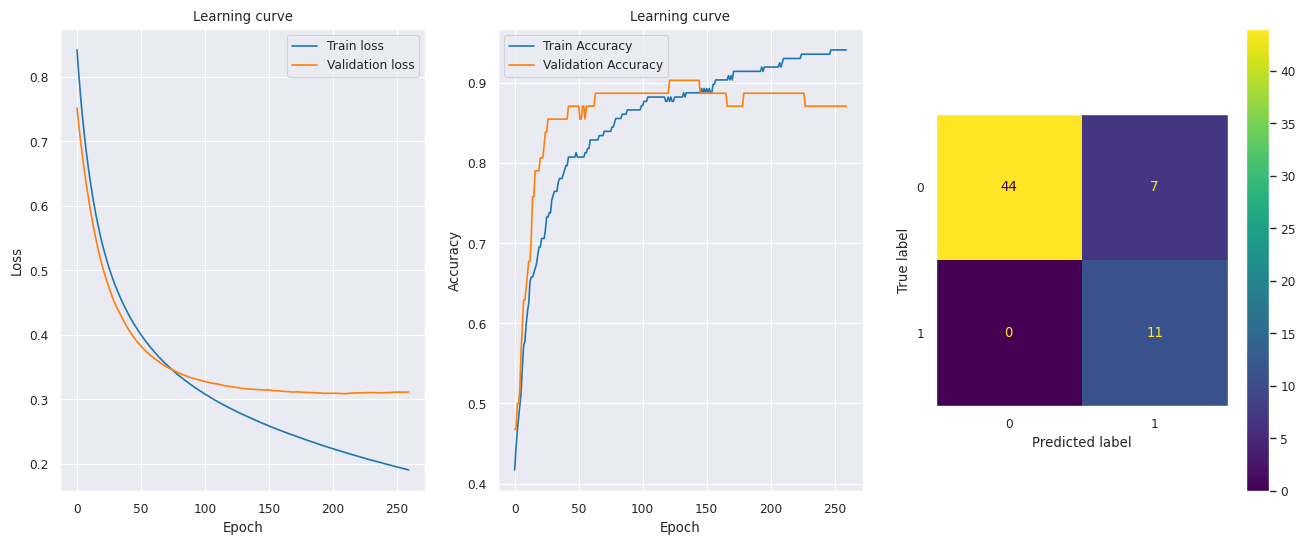

Fold 1 Init 0 Balanced Log Loss: 0.2756
Fold 1 Init 1 Balanced Log Loss: 0.1962
Fold 1 Init 2 Balanced Log Loss: 0.2493
Fold 1 Init 3 Balanced Log Loss: 0.2483
Fold 1 Init 4 Balanced Log Loss: 0.2271
Fold 1 Init 5 Balanced Log Loss: 0.1673
Fold 1 Init 6 Balanced Log Loss: 0.1752
Fold 1 Init 7 Balanced Log Loss: 0.1899
Fold 1 Init 8 Balanced Log Loss: 0.1743
Fold 1 Init 9 Balanced Log Loss: 0.2342
Fold 1 Balanced Log Loss: 0.1673
Fold 1 Accuracy: 0.9354838709677419


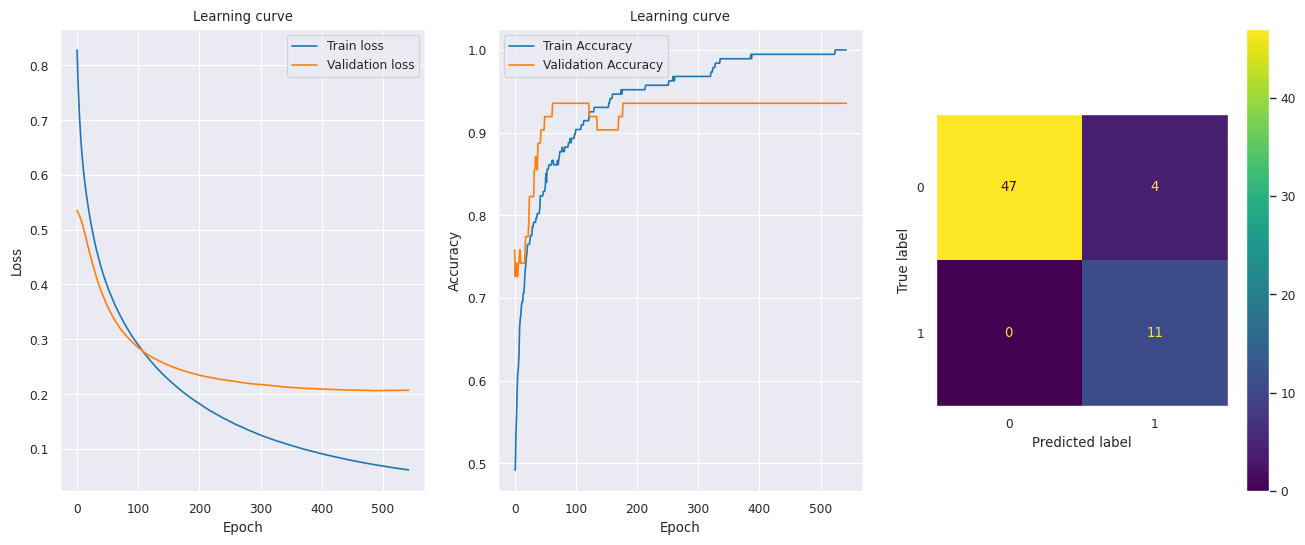

Fold 2 Init 0 Balanced Log Loss: 0.3120
Fold 2 Init 1 Balanced Log Loss: 0.2726
Fold 2 Init 2 Balanced Log Loss: 0.2671
Fold 2 Init 3 Balanced Log Loss: 0.2625
Fold 2 Init 4 Balanced Log Loss: 0.2400
Fold 2 Init 5 Balanced Log Loss: 0.2865
Fold 2 Init 6 Balanced Log Loss: 0.2683
Fold 2 Init 7 Balanced Log Loss: 0.2850
Fold 2 Init 8 Balanced Log Loss: 0.2973
Fold 2 Init 9 Balanced Log Loss: 0.2731
Fold 2 Balanced Log Loss: 0.2400
Fold 2 Accuracy: 0.8548387096774194


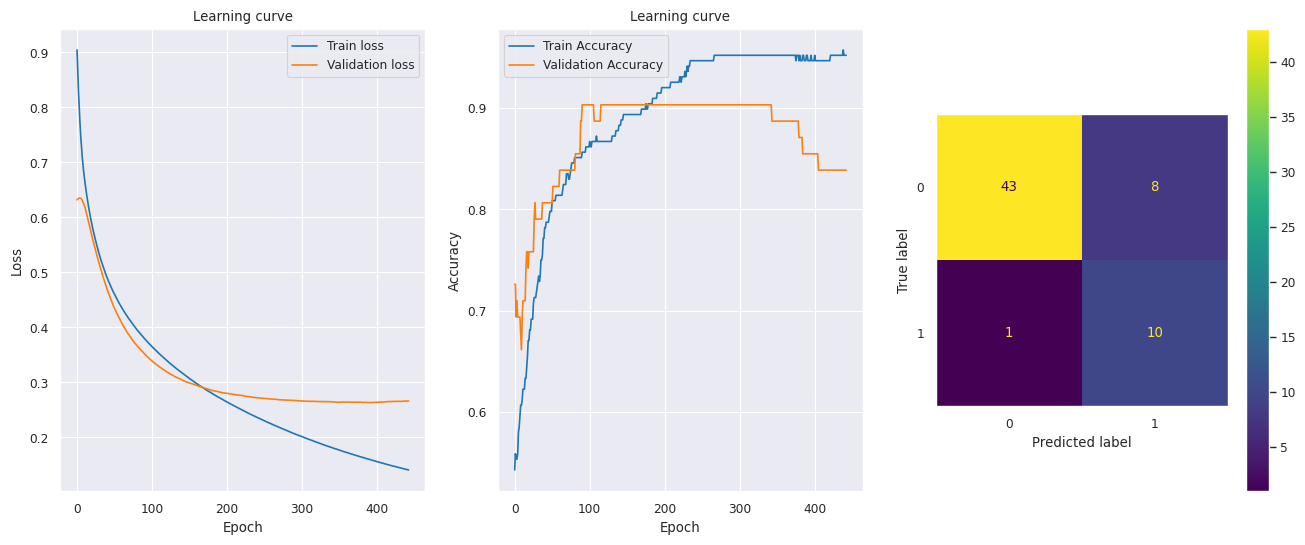

Fold 3 Init 0 Balanced Log Loss: 0.2865
Fold 3 Init 1 Balanced Log Loss: 0.1582
Fold 3 Init 2 Balanced Log Loss: 0.2233
Fold 3 Init 3 Balanced Log Loss: 0.2537
Fold 3 Init 4 Balanced Log Loss: 0.2270
Fold 3 Init 5 Balanced Log Loss: 0.2710
Fold 3 Init 6 Balanced Log Loss: 0.2588
Fold 3 Init 7 Balanced Log Loss: 0.2044
Fold 3 Init 8 Balanced Log Loss: 0.2166
Fold 3 Init 9 Balanced Log Loss: 0.2160
Fold 3 Balanced Log Loss: 0.1582
Fold 3 Accuracy: 0.9032258064516129


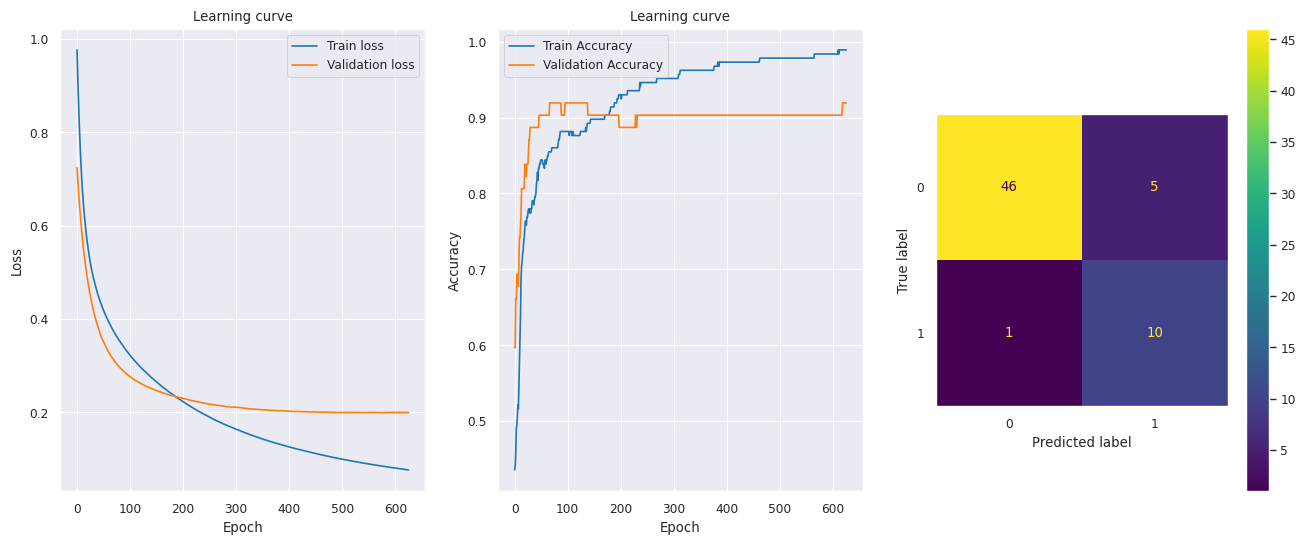

Fold 4 Init 0 Balanced Log Loss: 0.4006
Fold 4 Init 1 Balanced Log Loss: 0.3495
Fold 4 Init 2 Balanced Log Loss: 0.4152
Fold 4 Init 3 Balanced Log Loss: 0.3023
Fold 4 Init 4 Balanced Log Loss: 0.3275
Fold 4 Init 5 Balanced Log Loss: 0.3151
Fold 4 Init 6 Balanced Log Loss: 0.2958
Fold 4 Init 7 Balanced Log Loss: 0.3524
Fold 4 Init 8 Balanced Log Loss: 0.2825
Fold 4 Init 9 Balanced Log Loss: 0.3459
Fold 4 Balanced Log Loss: 0.2825
Fold 4 Accuracy: 0.8387096774193549


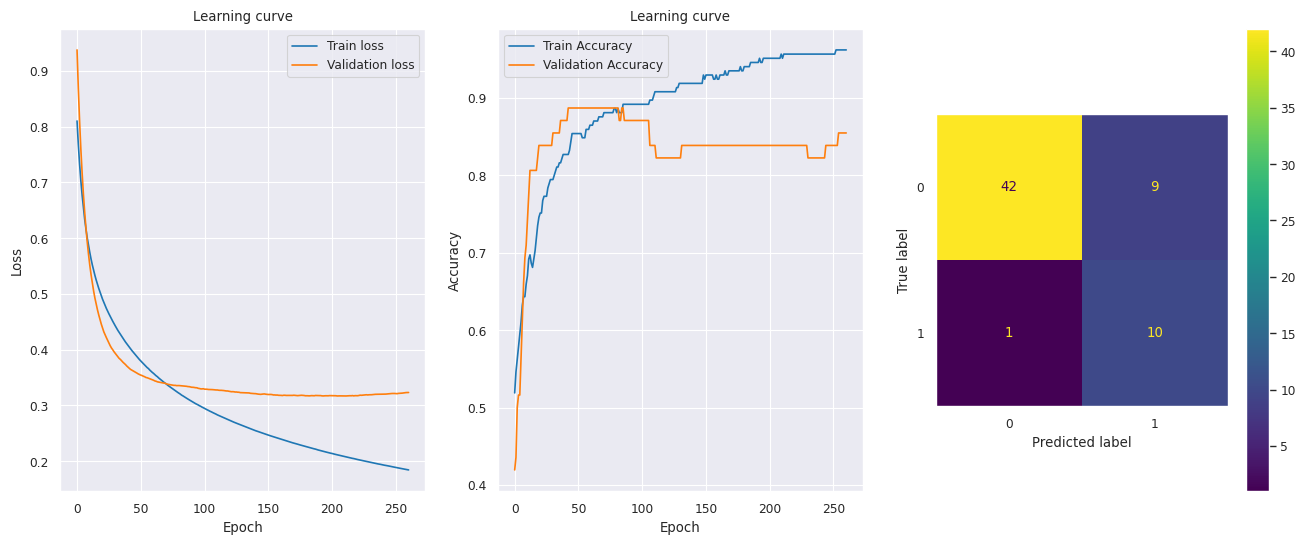

Best Fold: 3
Best Balanced Log Loss: 0.15823960485052074

CPU times: user 14min 15s, sys: 54.2 s, total: 15min 9s
Wall time: 15min 10s


In [8]:
%%time

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 10

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=[es], verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_logloss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model,
        'balanced_logloss': score,
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

## Evaluation

In [9]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x7e9c701d5240>,
 'balanced_logloss': 0.15823960485052074}

In [10]:
# Ensure test has same features as trained model
test_cols = test.columns
features = [c for c in X.columns if c in test_cols]
test = test[features]

test_imp = pd.DataFrame(cv_data[best_fold]['knn_imputer'].transform(test), columns=test.columns, index=test.index)
test_scaled = pd.DataFrame(cv_data[best_fold]['scaler'].transform(test_imp), columns=test_imp.columns, index=test_imp.index)
test_pca = pd.DataFrame(cv_data[best_fold]['pca'].transform(test_scaled), index=test_scaled.index)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

array([[0.9531907],
       [0.9531907],
       [0.9531907],
       [0.9531907],
       [0.9531907]], dtype=float32)

### Prepare Submission

In [11]:
sub['class_0'] = 1 - test_pred
sub['class_1'] = test_pred
sub

,Id,class_0,class_1
0,00eed32682bb,0.046809,0.953191
1,010ebe33f668,0.046809,0.953191
2,02fa521e1838,0.046809,0.953191
3,040e15f562a2,0.046809,0.953191
4,046e85c7cc7f,0.046809,0.953191


In [12]:
sub.to_csv('/kaggle/working/submission.csv', index=False)